# Common Library

In [1]:
import os
import sys
import numpy as np 
from scipy.stats import gamma
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import nibabel as nb
from nltools.data import Brain_Data
from collections import Counter

# rsatoolbox
from rsatoolbox.data.noise import prec_from_residuals
from rsatoolbox.util.searchlight import get_volume_searchlight
from rsatoolbox.data.dataset import Dataset
from rsatoolbox.rdm import calc_rdm

# boostrsa
from boostrsa import searchlight
from boostrsa.boostrsa_types import ShrinkageMethod
from boostrsa.searchlight import calc_sl_rdm_crossnobis

In [2]:
from numba import cuda
cuda.select_device(0)
device = cuda.get_current_device()
print("GPU: ", device)

GPU:  <CUDA device 0 'b'NVIDIA GeForce RTX 3090''>


# Configuration

In [3]:
# Set your cuda path 
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.4" # for linux

# Generate datas

## Simulation parameters

In [4]:
# Brain
brain_shape = (30, 40, 30)
nx, ny, nz = brain_shape
n_vox = nx * ny * nz 

# Create an affine transformation matrix (2mm isotropic voxels, no rotation)
affine = np.diag([2, 2, 2, 1])

# Simulation experiment parameters
n_timepoints = 300  # total time points
stimuli_types = {
    "stim1" : 4,
    "stim2" : 3,
    "stim3" : 2,
    "stim4" : 1,
}
stimuli = list(stimuli_types.keys())
response_duration = 10  # duration of response in timepoints
n_run = 3

# HRF Parameters
hrf_times = np.arange(0, 30, 1)  # 30 time points for the HRF
peak = 6
undershoot = 12
ratio = 0.35
hrf = gamma.pdf(hrf_times, peak) - ratio * gamma.pdf(hrf_times, undershoot)

# Response parameter
response_amplitudes = {
    "stim1" : 3,
    "stim2" : 2,
    "stim3" : 1,
    "stim4" : 0.5,
}

## Simulate experiment

In [5]:
stimulus_timings = np.zeros(n_timepoints)

current_time = 0
while current_time < n_timepoints:
    stimulus = np.random.choice(stimuli)
    onset = current_time
    duration = response_duration
    offset = min(current_time + duration, n_timepoints)
    
    # Simulate response
    stimulus_timings[onset:offset] += stimuli_types[stimulus]
    
    # Add next stimulus interval
    isi = np.random.randint(5, 15)
    current_time += duration + isi
    
stimulus_timings = pd.Series(stimulus_timings)

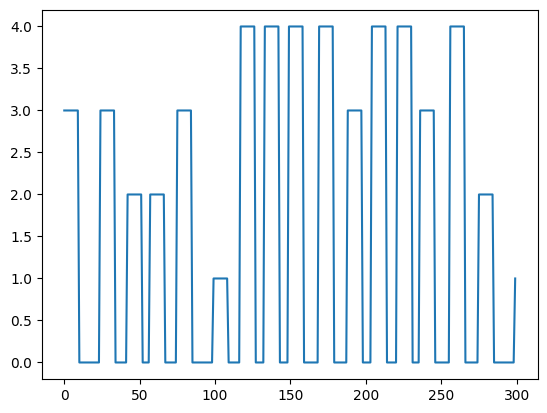

In [6]:
plt.plot(stimulus_timings)

## Simulate brain response

In [7]:
# Convolve with the HRF
data_convolved = np.convolve(stimulus_timings, hrf, mode='full')[:n_timepoints]

In [8]:
# fmri
fmri_data = np.zeros((n_run, brain_shape[0], brain_shape[1], brain_shape[2], n_timepoints))

noise_level = 0.5
for run_i in range(n_run):
    data_convolved += np.random.normal(0, noise_level * (run_i+1), n_timepoints) # Add Gaussian noise
    fmri_data[run_i, :,:,:] = data_convolved

In [9]:
# Mask
mask = np.zeros(brain_shape).astype(np.uint8)
mask[5:25, 5:25, 5:25] = 1
mask_3d_indexes = np.array(np.where(mask == 1))
mask_1d_indexes = np.ravel_multi_index(mask_3d_indexes, (nx, ny, nz))

# Get beta values & residuals

In [10]:
unique_stimuli = np.unique(stimulus_timings[stimulus_timings > 0])

In [11]:
# Initialize design matrix with zero columns
design_matrix = np.zeros((stimulus_timings.size, 1 + unique_stimuli.size))

# Fill in the design matrix
for index, stimulus in enumerate(unique_stimuli):
    box_regressor = (stimulus_timings == stimulus).astype(int)
    
    # Convolve with the HRF
    regressor = np.convolve(box_regressor, hrf, mode='full')[:n_timepoints]
    
    design_matrix[:, index + 1] = regressor
    
# Bias
design_matrix[:, 0] = 1

design_matrix = pd.DataFrame(design_matrix)
design_matrix.columns = ["bias"] + stimuli

In [12]:
plt.plot(design_matrix)
plt.legend(design_matrix.columns, loc = (1.1, 0))

In [13]:
# Simulated fmri brain data
fmri_data_brain = [Brain_Data(nb.Nifti1Image(run_data, affine)) for run_data in fmri_data]

# Masked brain
fmri_data_brain = [fmri_data.apply_mask(nb.Nifti1Image(mask, affine)) for fmri_data in fmri_data_brain]

/home/seojin/anaconda3/envs/boostrsa/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/seojin/anaconda3/envs/boostrsa/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/seojin/anaconda3/envs/boostrsa/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to th

In [56]:
# Do linear regression
betas = []
residuals = []
for run_index in range(n_run):
    fmri_data_brain[run_index].X = design_matrix
    regress_result = fmri_data_brain[run_index].regress()
    
    # Result
    beta = regress_result["beta"]
    residual = regress_result["residual"]
    
    betas.append(beta)
    residuals.append(residual)

# Make appropriate format

Following values' shapes must be matched.

- beta
    - shape: (the number of condition, the number of target voxel)
- residual
    - shape: (the number of session, the number of times on a session, the number of target voxel)
- condition
    - shape (the number of condition)
- session
    - shape: (the number of condition)

In [58]:
# numpy format beta
np_betas = [beta.data[list(design_matrix.columns).index("stim1"):list(design_matrix.columns).index("stim4") + 1] for beta in betas]
np_betas = np.concatenate(np_betas, axis = 0)

# numpy format residual
np_residuals = np.array([residual.data for residual in residuals])

In [59]:
# condition of corresponding beta value
conditions = [np.array(stimuli) for _ in range(n_run)]

In [60]:
# session(run) of corresponding beta value
sessions = []
for run_index in range(n_run):
    sessions += list(np.repeat(run_index + 1, len(conditions[run_index])))
sessions = np.array(sessions)

In [61]:
conditions = np.concatenate(conditions)

# Searchlight region

In [51]:
radius = 3
threshold = 1

centers, neighbors = get_volume_searchlight(mask, 
                                            radius=radius, 
                                            threshold=threshold)

Finding searchlights...: 100%|██████████| 8000/8000 [00:00<00:00, 10621.83it/s]


Found 4096 searchlights


In [62]:
# Filter voxels which have unmatched neighbors 
n_neighbors = np.array([neighbor.shape[-1] for neighbor in neighbors])
most_n_neighbor = Counter(n_neighbors).most_common(1)[0][0]
flags = n_neighbors == most_n_neighbor

centers = centers[flags]
neighbors = [ne for flag, ne in zip(flags, neighbors) if flag == True]
neighbors = np.array(neighbors)

# Searchlight - CPU version

In [67]:
subj_number = 1

n_center = len(centers)
for i in tqdm(range(n_center)):
    center = centers[i]
    neighbor = neighbors[i]
    
    # Mask
    n_channel = np_betas.shape[1]
    mask_out = np.zeros(n_channel)
    for neighbor_pos in neighbor:
        for brain_i, brain_pos in enumerate(mask_1d_indexes):
            if brain_pos == neighbor_pos:
                mask_out[brain_i] = 1
    
    # Beta
    masked_betas = np_betas[:, mask_out == 1]
    
    # Residual
    masked_residuals = np_residuals[:, :, mask_out == 1]
    
    # Precision matrix
    noise_precision_mats = prec_from_residuals(masked_residuals, method = "shrinkage_eye")
    
    # Crossnobis
    measurements = masked_betas
    nVox = measurements.shape[-1]
    des = {'subj': subj_number}
    obs_des = {'conds': conditions, 'sessions': sessions}
    chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}

    dataset = Dataset(measurements = measurements,
                      descriptors = des,
                      obs_descriptors = obs_des,
                      channel_descriptors = chn_des)
    rdm_crossnobis = calc_rdm(dataset, 
                          descriptor='conds', 
                          method='crossnobis',
                          noise=noise_precision_mats,
                          cv_descriptor='sessions')


  1%|          | 23/4096 [00:03<08:58,  7.56it/s]


KeyboardInterrupt: 

# Searchlight - GPU version

In [81]:
n_split_data = 2048

In [75]:
sl_precisions = searchlight.calc_sl_precision(residuals = np_residuals,
                                              neighbors = neighbors,
                                              n_split_data = n_split_data,
                                              masking_indexes = mask_1d_indexes,
                                              shrinkage_method = ShrinkageMethod.shrinkage_diag)
sl_precisions = np.concatenate(sl_precisions)

  0%|          | 0/3 [00:00<?, ?it/s]

shrinakge method: shrinkage_diag


 33%|███▎      | 1/3 [00:30<01:00, 30.35s/it]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (2000, 3, 300) + inhomogeneous part.

In [71]:
sl_rdms, rdm_conds = calc_sl_rdm_crossnobis(n_split_data = n_split_data,
                                            centers = centers,
                                            neighbors = neighbors,
                                            precs = sl_precisions,
                                            measurements = np_betas,
                                            masking_indexes = mask_1d_indexes,
                                            conds = conditions,
                                            sessions = sessions)
sl_rdms = np.concatenate(sl_rdms)

NameError: name 'sl_precisions' is not defined

In [ ]:
# Make sl_rdms
sl_rdms = rdm.RDMs(sl_rdms,
            pattern_descriptors = {
                "index" : list(np.arange(0, len(rdm_conds))),
                "events" : list(rdm_conds),
            },
            rdm_descriptors = {
                "voxel_index" : target_centers,
                "index" : np.arange(0, len(target_centers))
            })
sl_rdms.dissimilarity_measure = "crossnobis"